In [157]:
from pymatgen.core.surface import Slab, SlabGenerator
from pymatgen import Structure, Specie, Element
from pymatgen.core.sites import PeriodicSite
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.analysis.local_env import BrunnerNN_reciprocal, CrystalNN, VoronoiNN, BrunnerNN_real
import os
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import warnings
warnings.filterwarnings('once')
import matplotlib as mpl
### Matplotlib style ###
mpl.rcParams['figure.figsize'] = (7.0,6.0)


In [158]:
def slab_from_file(hkl, filename):
    """
    reads in structure from the file and returns slab object.
    Args:
         hkl (tuple): miller index of the slab in the input file.
         filename (str): structure file in any format
                   supported by pymatgen
    Returns:
         Slab object
    """
    slab_input = Structure.from_file(filename)
    return Slab(slab_input.lattice,
                slab_input.species_and_occu,
                slab_input.frac_coords,
                hkl,
                Structure.from_sites(slab_input, to_unit_cell=True),
                shift=0,
                scale_factor=np.eye(3, dtype=np.int),
                site_properties=slab_input.site_properties)

In [159]:
def parse_conv_dirs(hkl, bulk_per_atom): 
    
    d = []
    hkl_sorted = ''.join(map(str, hkl))
    
    for root, fols, files in os.walk('.'): 
        for fol in fols: 
            if not any([fol=='setup', fol==root, fol=='.ipynb_checkpoints']): 
                path = os.path.join(root, fol)
                psc = '{}/POSCAR'.format(path)
                vsp = '{}/vasprun.xml'.format(path)
                structure = Structure.from_file(psc)
                vasprun = Vasprun(vsp)
                slab = slab_from_file(hkl, psc)

                area = slab.surface_area
                atoms = len(structure.atomic_numbers)
                slab_energy = vasprun.final_energy
                energy_per_atom = slab_energy / atoms

                surf_energy = (slab_energy - bulk_per_atom * atoms)/(2 * area) * 16.02
            
                #name of fol has to be ./slab_vac 
                slab_vac = fol.split('_')
                d.append({'slab_thickness': slab_vac[1], 
                          'vac_thickness': slab_vac[2],
                          'suface_energy': surf_energy, 
                          'slab_toten': slab_energy,
                          'slab_per_atom': energy_per_atom})

                
    df = pd.DataFrame(d)
    df.to_csv('{}_data.csv'.format(hkl_sorted), index=False)
    
    return df 


In [106]:
def bond_analysis(struc, atoms, nn_method=VoronoiNN(tol=0.1, cutoff=10)):
    bonds_info = []
    struc.add_oxidation_state_by_guess
    
    for n, pos in enumerate(struc):
        for atom1, atom2 in atoms:
            if pos.specie.symbol == atom1:
                nearest_neighbours =  nn_method.get_nn_info(struc, n)
                matched_sites = []
                for d in nearest_neighbours:           
                    if d.get('site').specie.symbol == atom2: 
                        matched_sites.append(d)  
                bond_distances = [struc.get_distance(n,x['site_index']) for x in matched_sites]
                bonds_info.append({'{}_index'.format(atom1): n+1, 
                                   '{}_c_coord'.format(atom1): pos.c, 
                                   '{}-{}_bond_distance'.format(atom1,atom2): np.mean(bond_distances)})
    df = pd.DataFrame(bonds_info)
    df.to_csv('bond_analysis_data.csv', index=False)

    return df


    Y_index  Y_c_coord  Y-S_bond_distance  Ti_index  Ti_c_coord  \
0       1.0   0.288218           2.831534       NaN         NaN   
1       2.0   0.329885           2.821278       NaN         NaN   
2       3.0   0.253449           2.805894       NaN         NaN   
3       4.0   0.295115           2.821278       NaN         NaN   
4       5.0   0.267385           2.831534       NaN         NaN   
..      ...        ...                ...       ...         ...   
91      NaN        NaN                NaN      92.0    0.701255   
92      NaN        NaN                NaN      93.0    0.694579   
93      NaN        NaN                NaN      94.0    0.736245   
94      NaN        NaN                NaN      95.0    0.722088   
95      NaN        NaN                NaN      96.0    0.680421   

    Ti-O_bond_distance  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..                 ...  
91            1.9193

In [154]:
def plot_bond_analysis(atoms): 
    #atoms are a list of tuples you want to compare, in the same order as in bond_analysis()
    df = pd.read_csv('bond_analysis_data.csv')
    colors = plt.rcParams["axes.prop_cycle"]()
    
    legend_list = []
    fig, axs = plt.subplots(len(atoms))
    
    i=0
    for atom1, atom2 in atoms:
        c = next(colors)["color"]
        x = df['{}_c_coord'.format(atom1)] 
        y = df['{}-{}_bond_distance'.format(atom1,atom2)]
        axs[i].scatter(x, y, marker='x', color=c)
        axs[i].set_ylabel("Bond distance / Å ")
        axs[i].legend(['{}-{} bond'.format(atom1, atom2)])
        i+=1
    
    plt.xlabel("Fractional coordinates")
    plt.show()


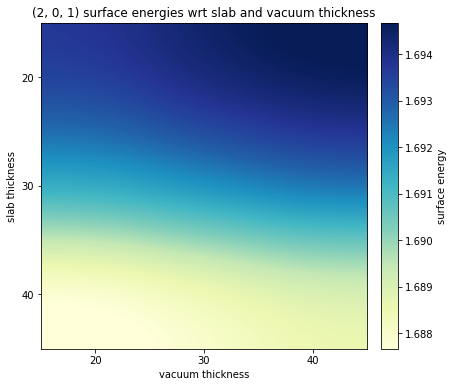

None


In [27]:
def plot_surface_energy(hkl, *args):
    
    hkl_sorted = ''.join(map(str, hkl))
    df = pd.read_csv('{}_data.csv'.format(hkl_sorted))
    
    df2 = df.pivot(index='slab_thickness', 
                  columns='vac_thickness', 
                  values='surface_energy')
    
    ax = plt.gca()
    ax.set_yticks(list(range(len(df2.index))))
    ax.set_yticklabels(df2.columns)
    ax.set_xticks(list(range(len(df2.columns))))
    ax.set_xticklabels(df2.columns)
    im = plt.imshow(df2, cmap='YlGnBu', interpolation='mitchell')
    plt.ylabel('slab thickness')
    plt.xlabel('vacuum thickness')
    plt.title('{} surface energies wrt slab and vacuum thickness'.format(hkl))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('surface energy')
    plt.savefig('surface_energy_conv.png')
    plt.show()
    

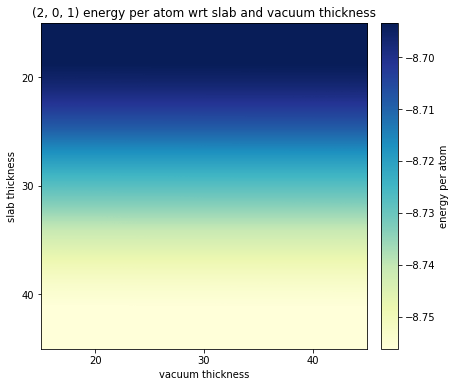

None


In [26]:
def plot_energy_per_atom(hkl, *args):
    
    hkl_sorted = ''.join(map(str, hkl))
    df = pd.read_csv('{}_data.csv'.format(hkl_sorted))
      
    df2 = df.pivot(index='slab_thickness', 
                  columns='vac_thickness', 
                  values='slab_per_atom')
    
    
    ax = plt.gca()
    ax.set_yticks(list(range(len(df2.index))))
    ax.set_yticklabels(df2.columns)
    ax.set_xticks(list(range(len(df2.columns))))
    ax.set_xticklabels(df2.columns)
    im = plt.imshow(df2, cmap='YlGnBu', interpolation='mitchell')
    plt.ylabel('slab thickness')
    plt.xlabel('vacuum thickness')
    plt.title('{} energy per atom wrt slab and vacuum thickness'.format(hkl))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('energy per atom')
    plt.savefig('energy_per_atom_conv.png')
    plt.show()


In [160]:
print(parse_conv_dirs((2,0,1),-8.83099767))
#plot_surface_energy((2,0,1))
#plot_energy_per_atom((2,0,1))

/anaconda3/lib/python3.7/site-packages/pymatgen/io/vasp/outputs.py:155: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn('Float overflow (*******) encountered in vasprun')


  slab_thickness vac_thickness  suface_energy   slab_toten  slab_per_atom
0             20            20       1.693613 -2295.063827      -8.693424
1             30            20       1.691520 -3072.236507      -8.727945
2             40            20       1.687669 -4238.010782      -8.756221
3             40            30       1.688262 -4237.998079      -8.756194
4             20            30       1.694248 -2295.050207      -8.693372
5             30            30       1.692059 -3072.224945      -8.727912
6             20            40       1.694674 -2295.041087      -8.693337
7             30            40       1.692583 -3072.213711      -8.727880
8             40            40       1.688834 -4237.985806      -8.756169


In [ ]:
test_slab = Structure.from_file('./slab_20_20/POSCAR')
test_bond_analysis = bond_analysis(test_slab, atoms=[('Y', 'S'), ('Ti', 'O')])
print(test_bond_analysis)
plot_bond_analysis([('Y', 'S'), ('Ti', 'O')])